
-----

# 📘 ML Project - Week 3: Model Creation, Evaluation & Tuning
-----

## 1\. Setup & Data Preparation
**Q1:** Import the necessary libraries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler , RobustScaler
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import pickle

sns.set(style="whitegrid")
%matplotlib inline

**Q2:** Load the  dataset and display the first 5 rows.

In [2]:
df = pd.read_csv('cardio_cleaned_week2.csv')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,MAP,bmi_cat
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.4,21.97,90.000000,2
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.4,34.93,106.666667,4
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.6,23.51,90.000000,2
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.2,28.71,116.666667,3
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.8,23.01,73.333333,2


**Q3:** Separate the dataset into Features (`X`) and Target (`y`).

In [3]:
X = df.drop(['cardio','age','bmi_cat', 'id'], axis=1)
y = df['cardio']

-----

## 2\. Train-Test Split (Step 1)
**Q4:** Split the dataset into Training(80%) and Testing (20%) .

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape:  {X_test.shape}")

Training Shape: (54912, 13)
Testing Shape:  (13729, 13)


-----

## 3\. Normalization / Scaling (Step 2)

**Q6:** Scale the data:

In [5]:
scaler = StandardScaler()
# scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data Scaled Successfully.")

Data Scaled Successfully.


-----

## 4\. Model Training 
**Q8:** Initialize the **Model**.

In [6]:
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model = RandomForestClassifier(
#     n_estimators=200,     
#     max_depth=10,         
#     min_samples_leaf=10,   
#     min_samples_split=10,
#     random_state=42
# # )

model1 = RandomForestClassifier(
    n_estimators=300,     
    max_depth=12,          
    min_samples_split=15, 
    min_samples_leaf=5,   
    max_features='log2',  
    bootstrap=True,
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1
)


In [7]:
model2 = GradientBoostingClassifier(
    n_estimators=300,        
    learning_rate=0.05,      
    max_depth=4,             
    min_samples_split=20,    
    min_samples_leaf=15,     
    subsample=0.8,           
    max_features='sqrt',     
    validation_fraction=0.1, 
    n_iter_no_change=10,     
    random_state=42
)

In [ ]:

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

model3 = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    min_child_weight=1,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=ratio,
    objective='binary:logistic',
    eval_metric='auc', 
    random_state=42,
    n_jobs=-1,
    enable_categorical=True
)

**Q9:** Train (fit) the model using the **Scaled Training Data**.

In [9]:
model1.fit(X_train_scaled, y_train)
print("Model Trained.")

Model Trained.


In [10]:
model2.fit(X_train_scaled, y_train)
print("Model Trained.")

Model Trained.


In [26]:
model3.fit(X_train_scaled, y_train)
print("Model Trained.")

Model Trained.


-----

## 5. Evaluation 

**Q10:** predictions on the **Scaled Test Set** (`X_test_scaled`).

In [12]:
y_pred1 = model1.predict(X_test_scaled)

In [13]:
y_pred2 = model2.predict(X_test_scaled)

In [27]:
y_pred3 = model3.predict(X_test_scaled)

**Q11:** Calculate the **Accuracy Score**.

In [15]:
accuracy1 = accuracy_score(y_test, y_pred1)
print(f"Test Accuracy: {accuracy1 * 100:.2f}%")

Test Accuracy: 73.19%


In [16]:
accuracy2 = accuracy_score(y_test, y_pred2)
print(f"Test Accuracy: {accuracy2 * 100:.2f}%")

Test Accuracy: 73.14%


In [28]:
accuracy3 = accuracy_score(y_test, y_pred3)
print(f"Test Accuracy: {accuracy3 * 100:.2f}%")

Test Accuracy: 73.22%


**Q12:** Display the **Confusion Matrix** using a Heatmap.


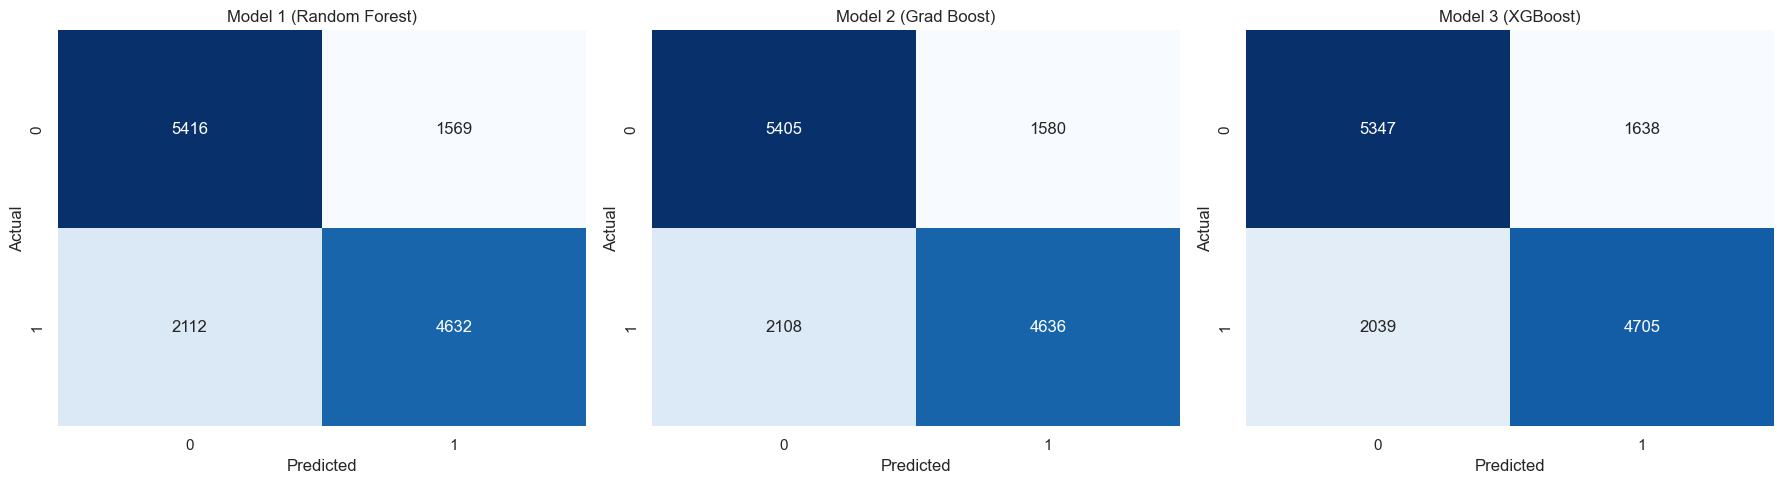

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
predictions = [y_pred1, y_pred2, y_pred3]
model_names = ['Model 1 (Random Forest)', 'Model 2 (Grad Boost)', 'Model 3 (XGBoost)']


for i, pred in enumerate(predictions):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
    axes[i].set_title(model_names[i])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')


plt.tight_layout()
plt.show()

**Q13:** Print the full **Classification Report** (Precision, Recall, F1-Score).

In [31]:
models = [model1, model2, model3] 
model_names = ['Random Forest', 'Gradient Boosting', 'XGBoost']
predictions = [y_pred1, y_pred2, y_pred3]

print("="*60)
print("FINAL MODEL COMPARISON REPORT")
print("="*60)

for name, pred in zip(model_names, predictions):
    print(f"\n--- {name} ---")
    print(classification_report(y_test, pred))

# fpr, tpr, thresholds = roc_curve(y_test, y_prob3)
# plt.figure(figsize=(6, 4))
# plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend()
# plt.show()

FINAL MODEL COMPARISON REPORT

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6985
           1       0.75      0.69      0.72      6744

    accuracy                           0.73     13729
   macro avg       0.73      0.73      0.73     13729
weighted avg       0.73      0.73      0.73     13729


--- Gradient Boosting ---
              precision    recall  f1-score   support

           0       0.72      0.77      0.75      6985
           1       0.75      0.69      0.72      6744

    accuracy                           0.73     13729
   macro avg       0.73      0.73      0.73     13729
weighted avg       0.73      0.73      0.73     13729


--- XGBoost ---
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      6985
           1       0.74      0.70      0.72      6744

    accuracy                           0.73     13729
   macro avg       0.73      0.

-----

## 6. Overfitting & Underfitting Check 

**Q14:** check Overfitting

In [32]:
y_train_pred = model3.predict(X_train_scaled)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred3)

print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Testing Accuracy:  {test_acc*100:.2f}%")

if (train_acc - test_acc) > 0.10:
    print("Warning: Potential Overfitting detected.")
else:
    print("Good Fit: Train and Test scores are balanced.")

Training Accuracy: 75.19%
Testing Accuracy:  73.22%
Good Fit: Train and Test scores are balanced.


-----

## 7. Hyperparameter Tuning 

**Q16:**  Grid Search Setup.

In [33]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

**Q17:** Run Tuning:

In [34]:
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_ * 100:.2f}%")

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Accuracy: 73.50%


-----

## 8\. Final Model Export

**Q20:** Save the best model .

In [35]:
data_to_save = {
    "model": best_model,
    "scaler": scaler
}

with open('cardio_model_week3.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

print("Model and Scaler saved to 'cardio_model_week3.pkl'")

Model and Scaler saved to 'cardio_model_week3.pkl'
